# Autoregressive Models: PixelCNN
---
## What is PixelCNN?  
PixelCNN is an autoregressive deep learning model designed for image generation. Unlike GANs or VAEs, which generate images holistically (all at once), PixelCNN generates images pixel by pixel in a raster-scan order (left to right, top to bottom).



*   This means each pixel is modeled conditionally based on previously generated pixels, allowing the network to learn a distribution over images.  


* Mathematically, PixelCNN models the joint distribution of an image $(\mathbf{x})$ as a product of conditional distributions:
$$
p(\mathbf{x}) = \prod_{i=1}^{N} p(x_i \mid x_1, x_2, \dots, x_{i-1})
$$

* where $( x_i )$ represents the value of the current pixel being generated  in the order (e.g., raster scan).


## How Does it Work?  
PixelCNN is based on **masked convolutions**, which ensure that when predicting a pixel, the model only has access to previously generated pixels i.e, it can't see the future or it's own value, each pixel should only be aware only of the previous pixels (Auto-regressivenes property), so in order to do that we somehow mask the future pixels regarding the current one, we will discuss it in further details.


Let's begin!

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


## Masked Convolutions

* At the begining of generative models, RNNs were used to generate pixels, (i.e, PixelRNN).

* Just as language models LSTMs were used in images too in order to generate the next pixel given all the previous ones.

* This was Super inefficient since images are Grids by defenition, thus can be parallelized instead of being sequentially processed as word tokens.

* So the goal now is to find a way to make this parallelizable and also keeping the auto-regressiveness property Thus **Masked Convolutions** were introduced.

### Example:
assume a 3*3 kernel.

* In regular convolutions, the kernel sees all 9 pixels

* In masked convolution, the kernel should only see exactly 4 pixels (assuming the current pixel is the center pixel)

* There are also special cases regarding the current position of a pixel







In [6]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in ['A', 'B'], "Mask type must be 'A' or 'B'"
        self.register_buffer('mask', self.weight.data.clone())
        _, _, H, W = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, H // 2, W // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, H // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask  # Apply mask
        return super().forward(x)

class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, kernel_size=7, num_layers=6):
        super().__init__()
        self.layers = nn.ModuleList()
        
        # First layer: Mask type A
        self.layers.append(MaskedConv2d(input_channels, hidden_channels, kernel_size, padding=kernel_size//2, mask_type='A'))
        self.layers.append(nn.ReLU())

        # Hidden layers: Mask type B
        for _ in range(num_layers - 2):
            self.layers.append(MaskedConv2d(hidden_channels, hidden_channels, kernel_size, padding=kernel_size//2, mask_type='B'))
            self.layers.append(nn.ReLU())

        # Final layer: 1x1 convolution for pixel probability prediction
        self.layers.append(nn.Conv2d(hidden_channels, input_channels, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)  # Pixel values between 0 and 1


## Data Preprocessing and Dataloaders


### 1. **Change the images to Tensors.**


### 2. **Load the MNIST dataset.**
* The dataset contains 60,000 images.
* We split them into 90% for training and 10% for testing.



### 4. **Prepare data loaders.**
* with Batch size of **64**




Using device: cuda


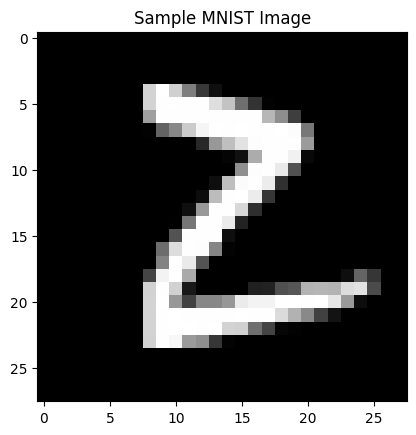

In [7]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Train-test split (90% train, 10% test)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Show a sample image
plt.imshow(train_dataset[0][0].squeeze(), cmap="gray")
plt.title("Sample MNIST Image")
plt.show()


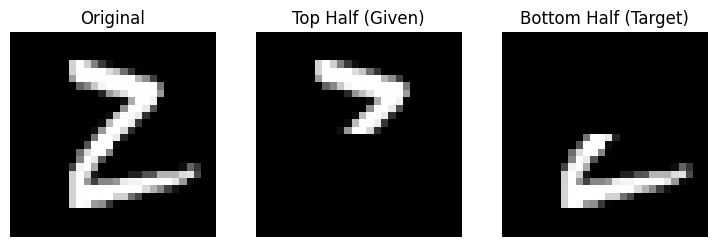

In [8]:
def split_top_bottom(images):
    """
    Splits an image into top-half (input) and bottom-half (target).
    """
    top_half = images.clone()
    bottom_half = images.clone()
    
    top_half[:, :, 14:, :] = 0  # Keep only the top half
    bottom_half[:, :, :14, :] = 0  # Keep only the bottom half
    
    return top_half, bottom_half

# Test splitting function
sample_image, _ = train_dataset[0]
top_half, bottom_half = split_top_bottom(sample_image.unsqueeze(0))  # Add batch dimension

# Show top-half and bottom-half
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].imshow(sample_image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(top_half.squeeze(), cmap="gray")
ax[1].set_title("Top Half (Given)")
ax[1].axis("off")

ax[2].imshow(bottom_half.squeeze(), cmap="gray")
ax[2].set_title("Bottom Half (Target)")
ax[2].axis("off")

plt.show()


In [9]:
# Initialize model, optimizer, and loss function
model = PixelCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for images, _ in loop:
        images = images.to(device)
        top_half, bottom_half = split_top_bottom(images)

        # Forward pass
        outputs = model(top_half)
        loss = criterion(outputs, bottom_half)  # Compare output with bottom half

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

print("Training complete!")


Training complete!


In [2]:
def complete_images(model, test_loader, num_samples=5):
    """
    Uses a trained model to complete the bottom half of given top-half images.
    """
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            top_half, _ = split_top_bottom(images)  # Get top half as input

            # Predict bottom half
            predicted_bottom_half = model(top_half)
            completed_images = top_half + predicted_bottom_half  # Merge both halves
            completed_images = completed_images.cpu().numpy()

            # Display results
            fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))
            for i in range(num_samples):
                axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
                axes[0, i].set_title("Original")
                axes[0, i].axis("off")

                axes[1, i].imshow(top_half[i].cpu().squeeze(), cmap="gray")
                axes[1, i].set_title("Given Top Half")
                axes[1, i].axis("off")

                axes[2, i].imshow(completed_images[i].squeeze(), cmap="gray")
                axes[2, i].set_title("Completed")
                axes[2, i].axis("off")

            plt.show()
            break  # Only show first batch

# Run inference on test data
complete_images(model, test_loader)


NameError: name 'model' is not defined

In [4]:
torch.save(model.state_dict(), "pixelcnn_model.pth")


NameError: name 'model' is not defined